In [1]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import imblearn
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import time
from sklearn.neighbors import KNeighborsClassifier

Loading the training and test data.

In [2]:
train_df = pd.read_csv('train_small.csv', header=None)
test_df = pd.read_csv('test_small.csv')

Generating new features and adding them to the dataset. This will be a part of out model if it is included. it is therefor important to add the same features for each sample that we want to classify.

In [3]:
idx = features = train_df.columns.values[2:]
train_df['sum'] = train_df[idx].sum(axis=1)  
train_df['min'] = train_df[idx].min(axis=1)
train_df['max'] = train_df[idx].max(axis=1)
train_df['mean'] = train_df[idx].mean(axis=1)
train_df['std'] = train_df[idx].std(axis=1)
train_df['skew'] = train_df[idx].skew(axis=1)
train_df['kurt'] = train_df[idx].kurtosis(axis=1)
train_df['med'] = train_df[idx].median(axis=1)

The data is split into training and test data. We are careful to split the set before we do imbalance correction.

In [4]:
num_training_samples = 20000
num_total_samples = 40000
train_targets = train_df.iloc[1:num_training_samples,1]
train_data = train_df.iloc[1:num_training_samples,2:]
test_targets = train_df.iloc[num_training_samples:num_total_samples,1]
test_data = train_df.iloc[num_training_samples:num_total_samples,2:]

# Organise the data into numpy arrays so that it is handled correctly by imblearn
nump_train_data = train_data.to_numpy()
nump_train_data = nump_train_data.astype(float)
nump_train_targets = train_targets.to_numpy()
nump_train_targets = nump_train_targets.astype(int)

nump_test_data = test_data.to_numpy()
nump_test_data = nump_test_data.astype(float)
nump_test_targets = test_targets.to_numpy()
nump_test_targets = nump_test_targets.astype(int)

Due to the imbalanced data set, we try balance it using SMOTE, random oversampling, and tomek links in combination with random undersampling.

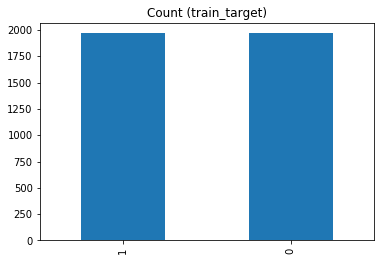

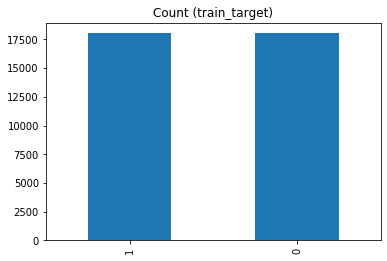

In [5]:
#Tomek links
tl = imblearn.under_sampling.TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(nump_train_data, nump_train_targets)

#Random undersampling
rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='auto',return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X_tl, y_tl)

#Random oversampling
ros = imblearn.over_sampling.RandomOverSampler()
X_ros, y_ros = ros.fit_sample(nump_train_data, nump_train_targets)

#SMOTE
smote = SMOTE(ratio='minority',  k_neighbors=40)
X_sm, y_sm = smote.fit_sample(nump_train_data, nump_train_targets)


# Comparison of balancing techniques

We compare SMOTE, random oversampling, tomek links in combination with random undersampling, and the original dataset in both XGBoost and KNN.

In [6]:
#KNN

def runKNN(X,y, technique):
    start = time.time()
    neigh = KNeighborsClassifier(n_neighbors=20)
    neigh.fit(X, y)
    preds = neigh.predict_proba(nump_test_data)
    end = time.time()
    print("\nKNN run on " + technique)
    print("  Run time: %.4f seconds " % (end - start))
    roc = roc_auc_score(test_targets, preds[:,1])
    print("  AUC: %.4f%% " % (roc * 100))
    

In [7]:
param = {'max_depth':6, 'eta':1, 'silent':1, 'objective':'binary:logistic', 'eval_metric':'auc'}
num_round = 1000

def runXGB(X,y,technique): #Runs XGBoost on a given dataset and prints the results
    dtrain = xgb.DMatrix(X, label=y)
    dtest = xgb.DMatrix(nump_test_data, label=nump_test_targets)

    start = time.time()

    model = xgb.train(param, dtrain, num_round)

    end = time.time()
    print("\nXGBoost run on " + technique)
    print("  Run time: %.4f seconds " % (end - start))

    preds = model.predict(dtest)
    roc = roc_auc_score(test_targets, preds)
    print("  AUC: %.4f%% " % (roc * 100))
    

In [8]:
runKNN(X_sm,y_sm,'data set balanced using SMOTE.')
runKNN(X_rus,y_rus,'data set balanced using tomek, followed by random undersampling.')
runKNN(X_ros,y_ros,'data set balanced using random oversampling.')
runKNN(nump_train_data,nump_train_targets,'data set without any balancing operations applied.')


KNN run on data set balanced using SMOTE.
  Run time: 272.3793 seconds 
  AUC: 54.4918% 

KNN run on data set balanced using tomek, followed by random undersampling.
  Run time: 32.2966 seconds 
  AUC: 60.9754% 

KNN run on data set balanced using random oversampling.
  Run time: 283.2325 seconds 
  AUC: 55.0638% 

KNN run on data set without any balancing operations applied.
  Run time: 151.0962 seconds 
  AUC: 56.4668% 


In [9]:
runXGB(X_sm,y_sm,'data set balanced using SMOTE.')
runXGB(X_rus,y_rus,'data set balanced using tomek, followed by random undersampling.')
runXGB(X_ros,y_ros,'data set balanced using random oversampling.')
runXGB(nump_train_data,nump_train_targets,'data set without any balancing operations applied.')


XGBoost run on data set balanced using SMOTE.
  Run time: 208.4323 seconds 
  AUC: 72.9676% 

XGBoost run on data set balanced using tomek, followed by random undersampling.
  Run time: 13.3264 seconds 
  AUC: 80.4524% 

XGBoost run on data set balanced using random oversampling.
  Run time: 159.5749 seconds 
  AUC: 81.0204% 

XGBoost run on data set without any balancing operations applied.
  Run time: 93.3897 seconds 
  AUC: 81.0340% 


XGBoost has the AUC as its evaluation metric and shouldn't be very affected by the imbalance in the dataset, this looks to be the case. The effect was small with the exception of SMOTE. The artifical samples generated by SMOTE appears to have worsened the data set and reduced the usefullness of the set.

KNN is a poor predictor for this dataset, but was chosen because of its sensitivity to imbalanced data. We can see that the tomek improved the results from KNN, while the other techniques didn't affect it much.